In [1]:
import os
import sys
import numpy as np
# import psycopg2
import sqlalchemy
import pandas as pd

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
# from rdkit.Chem.Draw import IPythonConsole
# # IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs
# IPythonConsole.ipython_useSVG=False
import cairosvg

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context='paper',
    font_scale=8/8.8,
#     context="talk",
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [2]:
print(os.getcwd())
sys.path.append('../../')
import rlmolecule
from examples.run_config import RunConfig
from rlmolecule.sql import Base, Session
from rlmolecule.sql.tables import GameStore, RewardStore, StateStore

/home/jlaw/projects/arpa-e/rlmolecule/rlmolecule_work/examples/logp


In [3]:
# connect to the db
config_file = "config/logp_eagle.yaml"
run_config = RunConfig(config_file)
engine = run_config.start_engine()
Session.configure(bind=engine)
session = Session()

In [13]:
def load_games_played(session, run_id):
#     print("Loading games")
    df = pd.read_sql(session.query(GameStore).filter_by(run_id=run_id).statement, session.bind)

    df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)
    df = df.sort_values('time_hours')
    df_games = df
    df_games.reset_index(drop=True, inplace=True)
#     print(df_games.tail(3))
    return df_games


def load_rewards(session, run_id):
#     print("Loading rewards")
    df = pd.read_sql(session.query(RewardStore).filter_by(run_id=run_id).statement, session.bind)
    # df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)
    df = df.sort_values('reward', ascending=False)
    df_rew = df
#     print(df_rew.tail(3))
    return df_rew


# modified from here: https://www.programcreek.com/python/?code=gablg1%2FORGAN%2FORGAN-master%2Futils%2Fmol_distance.py
def save_svg(svg, svg_file, dpi=300):
    with open(svg_file, 'w') as afile:
        # write the raw string of the svg to file
        # see https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#IPython.display.display
        afile.write(svg._repr_svg_())
    png_file = svg_file.replace('.svg', '.png')
    a_str = svg._repr_svg_().encode('utf-8')
    cairosvg.svg2png(bytestring=a_str, write_to=png_file, dpi=dpi)
    return


def draw_mols(df_rew, out_dir, top=12):
    mols = list(df_rew.head(top)['data'].apply(lambda x: Chem.MolFromSmiles(x['smiles'])))
    rewards = list(df_rew.head(20)['reward'].round(3))
    rewards = ['logP: ' + str(r) for r in rewards]
#     print(rewards)
    svg = Draw.MolsToGridImage(
        mols, molsPerRow=4, subImgSize=(200, 120),
        legends=rewards, useSVG=True)
    out_file = f"{out_dir}/top_{top}_mols.svg"
    print(out_file)
    save_svg(svg, out_file)
    return svg

In [10]:
def plot_reward_train_curves(df, log, out_dir, title=""):
    fig, axs = plt.subplots(sharex=True, nrows=2, figsize=(3, 2.75), dpi=150)
    axs[0].plot(df.time_hours, df.raw_reward, '.', ms=.75, label='games')
    axs[0].plot(df.time_hours, df.raw_reward.rolling(250, min_periods=50).quantile(.75), label='$r_{75}$')

    axs[1].plot(log.time_hours, log.policy_wrapper_loss, label='value loss')
    axs[1].plot(log.time_hours, log.policy_wrapper_1_loss, label='prior loss')

    axs[0].legend(loc='upper right', ncol=2, borderpad=0, borderaxespad=0,
                bbox_to_anchor=(1.1, 1.2), markerscale=10)
    axs[1].legend(
        loc='upper right', ncol=2,
        borderpad=0, borderaxespad=0.1,
        bbox_to_anchor=(1.1, 1.2))

    # axs[0].set_ylim([0, 250])
#     axs[0].set_ylim([0, 1.0])
    #axs[1].set_ylim([0, .7])
    #axs[1].set_xlim([-.01, 4])
    axs[0].set_ylabel('Reward')
    axs[1].set_ylabel('Policy Training')
    axs[1].set_xlabel('Time (hours)')

    plt.tight_layout()
    sns.despine(offset=5, trim=True)
    plt.suptitle(title, y=1.0)

    out_file = f"{out_dir}/training-and-reward.svg"
    print(out_file)
    os.makedirs(os.path.dirname(out_file), exist_ok=True)
    plt.savefig(out_file, bbox_inches="tight")
    plt.savefig(out_file.replace('.svg','.pdf'), bbox_inches="tight")
    plt.savefig(out_file.replace('.svg','.png'), bbox_inches="tight")
    plt.show()
    plt.close()

# Compare Experiment Results

In [6]:
from IPython.display import SVG, display

In [7]:
def main_results(run_id, session):
    working_dir = f"/projects/rlmolecule/jlaw/logp/{run_id}"
    # load the games played
    df_games = load_games_played(session, run_id)

    log_file = f"{working_dir}/policy_checkpoints/log.csv"
    print(f"Reading {log_file}")
    log = pd.read_csv(log_file)
    log['time'] = pd.to_datetime(log.time)
    log['time'] = pd.to_datetime(log.time)
    log['time_hours'] = (log.time - df_games.time.min()).apply(lambda x: x.total_seconds() / 3600)
#     print(log.tail(3))

    # now plot the results
    out_dir = f"{working_dir}/viz"
    plot_reward_train_curves(df_games, log, out_dir, title=run_id)

    # and draw the molecules
    df_rew = load_rewards(session, run_id)
    svg = draw_mols(df_rew, out_dir, top=12)
    display(svg)

Reading /projects/rlmolecule/jlaw/logp/20210420-CNO/policy_checkpoints/log.csv
/projects/rlmolecule/jlaw/logp/20210420-CNO/viz/training-and-reward.svg


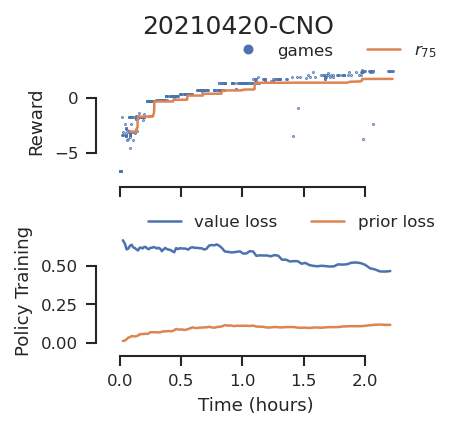

/projects/rlmolecule/jlaw/logp/20210420-CNO/viz/top_12_mols.svg


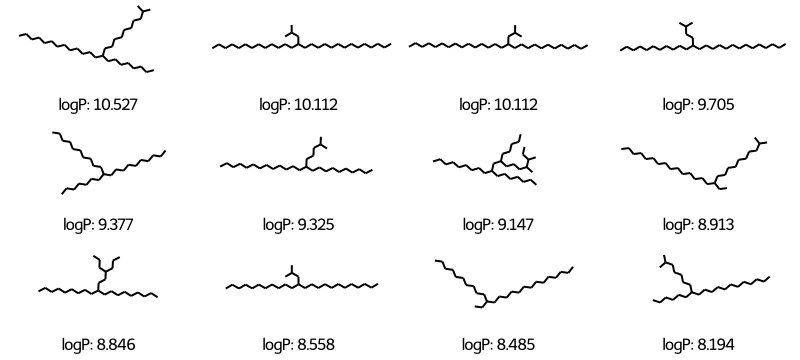

Reading /projects/rlmolecule/jlaw/logp/20210420-CNOS/policy_checkpoints/log.csv
/projects/rlmolecule/jlaw/logp/20210420-CNOS/viz/training-and-reward.svg


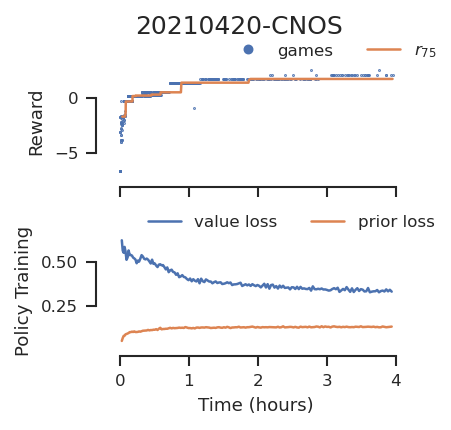

/projects/rlmolecule/jlaw/logp/20210420-CNOS/viz/top_12_mols.svg


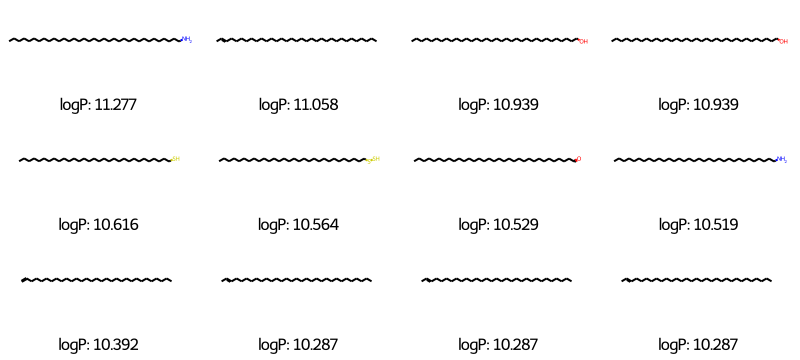

In [14]:
# initial results
for run_id in ["20210420-CNO", "20210420-CNOS"]:
    main_results(run_id, session)